In [1]:
import PIL,torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
# from torchvision.models import vgg16

In [2]:
class SkinDataset(Dataset):
    folds=5
    def __init__(self, root , num_classes,fold=0,training=False,n_augment=2):
        self.data_path = []
        self.sides =(256,256)
        self.n_augment = min(n_augment , 4)
        if training:
            self.transform = transforms.Compose([
                transforms.Resize((300,300)),
                transforms.RandomAffine(degrees=10),
                transforms.RandomCrop(size=self.sides),
                transforms.ToTensor(),
                transforms.Normalize(mean= [0.6075306,0.49116918 ,0.46066117],std = [0.22603881, 0.21623525, 0.2191065 ])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(self.sides),
                transforms.ToTensor(),
                transforms.Normalize(mean= [0.6075306,0.49116918 ,0.46066117],std = [0.22603881, 0.21623525, 0.2191065 ])
            ])
        self.training = training
        for label in range(num_classes):
            self.data_dir = os.path.join(root,os.listdir(root)[label])
            self.filename = os.listdir(self.data_dir)
            l = len(self.filename)
            inter = l//SkinDataset.folds
            picked = list(range(inter* fold,inter * (fold+1))) if not training else list(range(0,inter*fold))+list(range(inter*(fold+1),l))

            for i in picked:
                file_path = os.path.join(self.data_dir , self.filename[i])
#                 img = Image.open(fil)
                self.data_path.append((file_path, label))
    
    def __getitem__(self , index):
        index %= len(self.data_path)
        ddir , label = self.data_path[index]
        img = Image.open(ddir)
        imgmat = self.transform(img)
#         if self.training:
#             imgmat += torch.randn(3,self.sides,self.sides)/256
        result = (imgmat, label)
        del imgmat
        del img
        return result
    
    def __len__(self):
        if self.training:
            return len(self.data_path)*self.n_augment
        else:
            return len(self.data_path)

In [3]:
# del training_dataloader
batch_size = 32
training_dataset = SkinDataset(os.path.join(os.getcwd(),'../Skin40'), 40, training=True)
test_dataset = SkinDataset(os.path.join(os.getcwd(),'../Skin40'), 40)
training_dataloader = DataLoader(training_dataset , batch_size = batch_size , num_workers = 2, shuffle = True)
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , num_workers = 2, shuffle = True)

In [4]:
def train(model, train_loader, loss_func, optimizer, device):
    """
    train model using loss_fn and optimizer in an epoch.
    model: CNN networks
    train_loader: a Dataloader object with training data
    loss_func: loss function
    device: train on cpu or gpu device
    """
    total_loss = 0
    model.train()
    # train the model using minibatch
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        
        # forward
        outputs = model(images)
        loss = loss_func(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # every 100 iteration, print loss
        if (i + 1) % 50 == 0:
            print ("Step [{}/{}] Train Loss: {:.4f}"
                   .format(i+1, len(train_loader), loss.item()))
    return total_loss / len(train_loader)

In [5]:
def evaluate(model, val_loader, device, nclasses):
    """
    model: CNN networks
    val_loader: a Dataloader object with validation data
    device: evaluate on cpu or gpu device
    return classification accuracy of the model on val dataset
    """
    # evaluate the model
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        correct = 0
        total = 0
        cm = torch.zeros(nclasses, nclasses)
        for i, (images, targets) in enumerate(val_loader):
            # device: cpu or gpu
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            
            
            for t, p in zip(targets.view(-1), predicted.view(-1)):
                cm[t.long()][p.long()] +=1
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            
        accuracy = correct / total
        print('Accuracy on Test Set: {:.4f} %'.format(100 * accuracy))
        show_heatmap(cm, nclasses)
        return accuracy

In [6]:
import matplotlib.pyplot as plt
def show_curve(ys, title):
    """
    plot curlve for Loss and Accuacy
    Args:
        ys: loss or acc list
        title: loss or accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

def show_heatmap(cm, nclasses):
    labels = range(nclasses)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_yticks(labels)
    ax.set_yticklabels(labels)
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)
    
    im = ax.imshow(cm, cmap=plt.cm.hot_r )
    plt.colorbar(im)
    plt.title("Confusioin Matrix")
    plt.show()
    print('Accuracy of each class:\n', cm.diag()/(cm.sum(1)+1e-6))
    print('Recall of each class:\n', cm.diag()/(cm.sum(0)+1e-6))

In [7]:
def fit(model, num_epochs, optimizer, schedulr, device,nclasses):
    """
     train and evaluate an classifier num_epochs times.
    n and evaluate an classifier num_epochs times.
    We use optimizer and cross entropy loss to train the model. 
    Args: 
        model: CNN network
        num_epochs: the number of training epochs
        optimizer: optimize the loss function    loss_func.to(device)
    loss_func.to(device)
        schedulr: scheduling learning rate

    """
    # loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    
    model.to(device)
    loss_func.to(device)
    
    # log train loss and test accuracy
    losses = []
    accs = []
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}: , lr = {}'.format(epoch + 1, num_epochs , optimizer.param_groups[0]['lr']))
        # train step
        loss = train(model, training_dataloader, loss_func, optimizer, device)
        losses.append(loss)
        schedulr.step()
        
        # evaluate step
        accuracy = evaluate(model, test_dataloader, device,nclasses)
        accs.append(accuracy)
        
    
    # show curve
    show_curve(losses, "train loss")
    show_curve(accs, "test accuracy")

In [8]:
import os
wd = os.getcwd()
os.chdir(os.path.join(os.getcwd(),'../SAN'))
print(os.getcwd())

/home/jovyan/Documents/dataset_skin40/SAN


In [9]:
modelbest=torch.load('san19_pairwise/model/model_best.pth')
# sdict = modelbest['state_dict']
# for k,v in modelbest['state_dict'].items():
#     print(type(k),k, v.shape)

In [21]:
from model import san
net = san(sa_type=0, layers=(3, 3, 4, 6, 3), kernels=[3, 7, 7, 7, 7], num_classes=1000)
net.load_state_dict({k[7:]:v for k,v in modelbest['state_dict'].items()})
# net = modelbest
net.fc = torch.nn.Sequential(nn.Linear(2048, 4096),
                             nn.ReLU(inplace=True),
                             nn.Dropout(p=0.6),
                             nn.Linear(4096, 4096),
                             nn.ReLU(inplace=True),
                             nn.Dropout(p=0.5),
                             nn.Linear(4096, 40)
                            )
for k,v in net.state_dict().items():
    print(k, v.shape)

conv_in.weight torch.Size([64, 3, 1, 1])
bn_in.weight torch.Size([64])
bn_in.bias torch.Size([64])
bn_in.running_mean torch.Size([64])
bn_in.running_var torch.Size([64])
bn_in.num_batches_tracked torch.Size([])
conv0.weight torch.Size([64, 64, 1, 1])
bn0.weight torch.Size([64])
bn0.bias torch.Size([64])
bn0.running_mean torch.Size([64])
bn0.running_var torch.Size([64])
bn0.num_batches_tracked torch.Size([])
layer0.0.bn1.weight torch.Size([64])
layer0.0.bn1.bias torch.Size([64])
layer0.0.bn1.running_mean torch.Size([64])
layer0.0.bn1.running_var torch.Size([64])
layer0.0.bn1.num_batches_tracked torch.Size([])
layer0.0.sam.conv1.weight torch.Size([4, 64, 1, 1])
layer0.0.sam.conv1.bias torch.Size([4])
layer0.0.sam.conv2.weight torch.Size([4, 64, 1, 1])
layer0.0.sam.conv2.bias torch.Size([4])
layer0.0.sam.conv3.weight torch.Size([16, 64, 1, 1])
layer0.0.sam.conv3.bias torch.Size([16])
layer0.0.sam.conv_w.0.weight torch.Size([6])
layer0.0.sam.conv_w.0.bias torch.Size([6])
layer0.0.sam.conv_

In [11]:
os.chdir(wd)
print(os.getcwd())

/home/jovyan/Documents/dataset_skin40/SYSUDeepLearningSkin


In [18]:
net.fc

Sequential(
  (0): Linear(in_features=2048, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.6, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=40, bias=True)
)

In [29]:
# Hyper-parameters
num_epochs = 8
lr =8e-3
nclasses = 40
feature_tune=True
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cost = torch.nn.CrossEntropyLoss()
for parma in net.parameters():
    parma.requires_grad = feature_tune
for param in net.fc.parameters():
    param.requires_grad = True
# # optimizer
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
schedulr = torch.optim.lr_scheduler.StepLR(optimizer , step_size = 1 , gamma = 0.9)
for name,param in net.named_parameters():
    print(param.requires_grad, name)

True conv_in.weight
True bn_in.weight
True bn_in.bias
True conv0.weight
True bn0.weight
True bn0.bias
True layer0.0.bn1.weight
True layer0.0.bn1.bias
True layer0.0.sam.conv1.weight
True layer0.0.sam.conv1.bias
True layer0.0.sam.conv2.weight
True layer0.0.sam.conv2.bias
True layer0.0.sam.conv3.weight
True layer0.0.sam.conv3.bias
True layer0.0.sam.conv_w.0.weight
True layer0.0.sam.conv_w.0.bias
True layer0.0.sam.conv_w.2.weight
True layer0.0.sam.conv_w.3.weight
True layer0.0.sam.conv_w.3.bias
True layer0.0.sam.conv_w.5.weight
True layer0.0.sam.conv_w.5.bias
True layer0.0.sam.conv_p.weight
True layer0.0.sam.conv_p.bias
True layer0.0.bn2.weight
True layer0.0.bn2.bias
True layer0.0.conv.weight
True layer0.0.conv.bias
True layer0.1.bn1.weight
True layer0.1.bn1.bias
True layer0.1.sam.conv1.weight
True layer0.1.sam.conv1.bias
True layer0.1.sam.conv2.weight
True layer0.1.sam.conv2.bias
True layer0.1.sam.conv3.weight
True layer0.1.sam.conv3.bias
True layer0.1.sam.conv_w.0.weight
True layer0.1.sa

Epoch 1/8: , lr = 0.008
Step [50/120] Train Loss: 1.5934
Step [100/120] Train Loss: 2.2741
Accuracy on Test Set: 54.5833 %


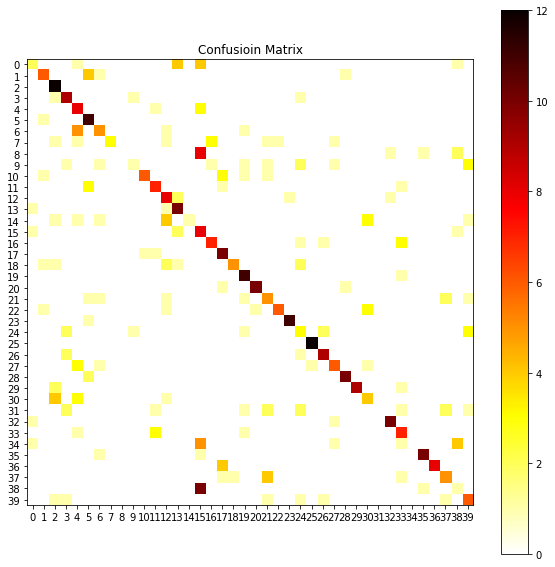

Accuracy of each class:
 tensor([0.1667, 0.5000, 1.0000, 0.7500, 0.6667, 0.9167, 0.4167, 0.2500, 0.0000,
        0.0833, 0.5000, 0.5833, 0.6667, 0.8333, 0.0833, 0.6667, 0.5833, 0.8333,
        0.4167, 0.9167, 0.8333, 0.4167, 0.5000, 0.9167, 0.2500, 1.0000, 0.7500,
        0.5000, 0.8333, 0.7500, 0.3333, 0.0000, 0.8333, 0.5833, 0.0000, 0.8333,
        0.6667, 0.4167, 0.0833, 0.5000])
Recall of each class:
 tensor([0.3333, 0.6000, 0.5217, 0.5294, 0.3478, 0.5000, 0.4545, 1.0000, 0.0000,
        0.3333, 0.8571, 0.5385, 0.4000, 0.5263, 1.0000, 0.2051, 0.6364, 0.5000,
        0.8333, 0.6111, 0.9091, 0.3333, 0.8571, 0.9167, 0.2308, 0.9231, 0.6923,
        0.6000, 0.8333, 1.0000, 0.3636, 0.0000, 0.8333, 0.4375, 0.0000, 0.8333,
        1.0000, 0.5000, 0.1111, 0.4000])
Epoch 2/8: , lr = 0.007200000000000001
Step [50/120] Train Loss: 1.0080
Step [100/120] Train Loss: 1.2828
Accuracy on Test Set: 64.3750 %


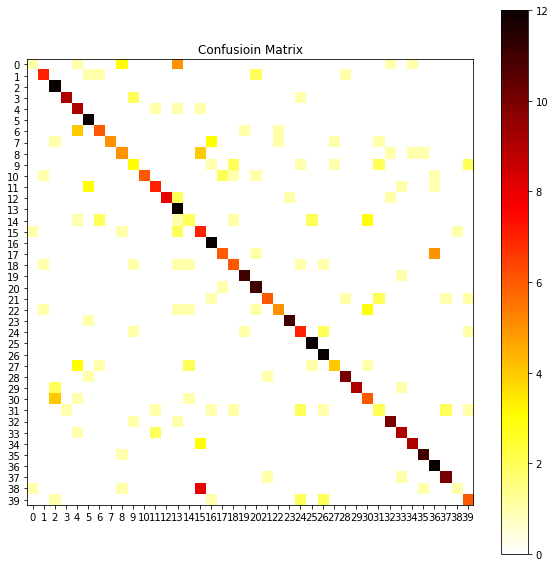

Accuracy of each class:
 tensor([0.0833, 0.5833, 1.0000, 0.7500, 0.7500, 1.0000, 0.5000, 0.4167, 0.4167,
        0.2500, 0.5000, 0.5833, 0.6667, 1.0000, 0.1667, 0.5833, 1.0000, 0.5000,
        0.5000, 0.9167, 0.9167, 0.5000, 0.4167, 0.9167, 0.5833, 1.0000, 1.0000,
        0.3333, 0.8333, 0.7500, 0.5000, 0.1667, 0.8333, 0.7500, 0.7500, 0.9167,
        1.0000, 0.8333, 0.0833, 0.5000])
Recall of each class:
 tensor([0.3333, 0.7000, 0.6000, 0.9000, 0.4500, 0.6667, 0.6000, 1.0000, 0.4545,
        0.3750, 1.0000, 0.6364, 1.0000, 0.4615, 0.2857, 0.3043, 0.6316, 0.6667,
        0.5455, 0.8462, 0.6875, 0.7500, 0.7143, 0.9167, 0.5000, 0.8000, 0.6667,
        0.6667, 0.8333, 1.0000, 0.4615, 0.2857, 0.7692, 0.6923, 0.8182, 0.8462,
        0.6316, 0.7692, 0.5000, 0.5455])
Epoch 3/8: , lr = 0.0064800000000000005
Step [50/120] Train Loss: 0.9186
Step [100/120] Train Loss: 0.7440
Accuracy on Test Set: 67.0833 %


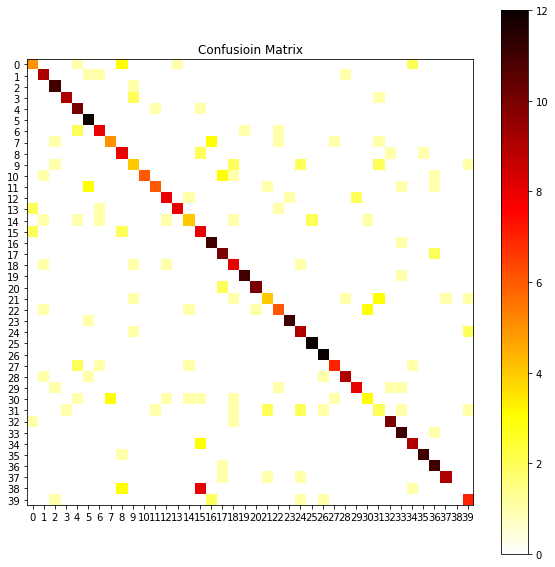

Accuracy of each class:
 tensor([0.4167, 0.7500, 0.9167, 0.7500, 0.8333, 1.0000, 0.6667, 0.4167, 0.6667,
        0.3333, 0.5000, 0.5000, 0.6667, 0.6667, 0.3333, 0.6667, 0.9167, 0.8333,
        0.6667, 0.9167, 0.8333, 0.3333, 0.5000, 0.9167, 0.7500, 1.0000, 1.0000,
        0.5833, 0.7500, 0.6667, 0.2500, 0.1667, 0.8333, 0.9167, 0.7500, 0.9167,
        0.9167, 0.7500, 0.0000, 0.5833])
Recall of each class:
 tensor([0.5000, 0.6429, 0.7333, 0.9000, 0.5882, 0.6667, 0.6667, 0.6250, 0.4706,
        0.4000, 1.0000, 0.7500, 0.7273, 0.8889, 0.5000, 0.3478, 0.6875, 0.5882,
        0.5000, 0.9167, 0.9091, 0.5000, 0.6000, 0.9167, 0.5625, 0.8571, 0.8000,
        0.7778, 0.8182, 0.8000, 0.4286, 0.2222, 0.8333, 0.6875, 0.6923, 0.9167,
        0.6875, 0.9000, 0.0000, 0.5833])
Epoch 4/8: , lr = 0.005832
Step [50/120] Train Loss: 0.6701
Step [100/120] Train Loss: 0.6683
Accuracy on Test Set: 68.1250 %


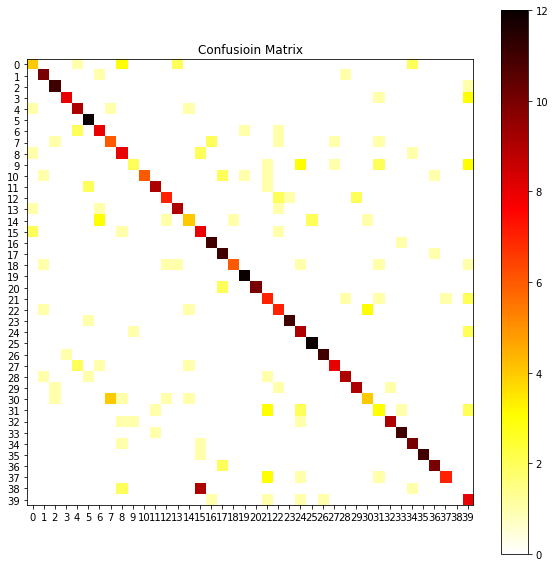

Accuracy of each class:
 tensor([0.3333, 0.8333, 0.9167, 0.6667, 0.7500, 1.0000, 0.6667, 0.5000, 0.6667,
        0.1667, 0.5000, 0.7500, 0.5833, 0.7500, 0.3333, 0.6667, 0.9167, 0.9167,
        0.5000, 1.0000, 0.8333, 0.5833, 0.5833, 0.9167, 0.7500, 1.0000, 0.9167,
        0.6667, 0.7500, 0.7500, 0.3333, 0.2500, 0.7500, 0.9167, 0.8333, 0.9167,
        0.8333, 0.5833, 0.0000, 0.6667])
Recall of each class:
 tensor([0.4444, 0.7143, 0.7857, 0.8889, 0.6429, 0.7500, 0.5714, 0.5455, 0.4706,
        0.5000, 1.0000, 0.8182, 0.7000, 0.7500, 0.5000, 0.3810, 0.7857, 0.6471,
        0.8571, 0.8571, 1.0000, 0.3889, 0.5000, 0.9167, 0.5000, 0.8571, 0.9167,
        0.8000, 0.8182, 0.8182, 0.5000, 0.3000, 0.9000, 0.8462, 0.7143, 1.0000,
        0.8333, 0.8750, 0.0000, 0.3636])
Epoch 5/8: , lr = 0.0052488000000000005
Step [50/120] Train Loss: 0.7899
Step [100/120] Train Loss: 0.3777


In [ ]:
# schedulr = torch.optim.lr_scheduler.StepLR(optimizer , step_size = 1 , gamma = 0.9)
fit(net, num_epochs, optimizer, schedulr,device, nclasses)  #

In [20]:
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cuda


In [ ]:
for i,(dat, tar) in enumerate(test_dataloader):
    print(i ,dat.shape, tar)
    if ( i>30):
        break

In [27]:
torch.save({'epoch':30 , 'state_dict':net.state_dict()}, '../baseSAN_chk0.pth')